<a href="https://colab.research.google.com/github/MimaDalix/Deep-Learning-tensorflow/blob/main/05_transfer_learning_tensorflow_part_2_fine_tuning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with tensorflow part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine Tuning

In [1]:
# Check if we're using a GPU 
!nvidia-smi

Thu Oct 20 12:59:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is very tedious

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

Wé've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-20 12:59:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-20 12:59:43 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we'll use in this notebooks 
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out, so you(ll have to redownload it if you want access to your helper functions.

## Let's get some data

This time, we'll see how we can use the pretrained models within `tf.keras.applications` and apply to our own problem (reconizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications 

In [4]:
# Get 10% of training data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-10-20 12:59:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   189MB/s    in 0.9s    

2022-10-20 12:59:47 (189 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset 
walk_through_dir("10_food_class_10_percent")

In [6]:
# Create training and testing directory paths 
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch data 
for images,labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.12755108e+00 3.12755084e+00 0.00000000e+00]
   [4.19387817e+00 5.19387817e+00 5.96939027e-01]
   [5.58163261e+00 6.58163261e+00 1.58163261e+00]
   ...
   [3.13418388e+01 3.55561028e+01 3.85561028e+01]
   [3.42143135e+01 3.52143135e+01 4.02143135e+01]
   [3.23570023e+01 3.26427193e+01 3.79998589e+01]]

  [[3.50000048e+00 4.50000048e+00 0.00000000e+00]
   [5.92346954e+00 6.92346954e+00 1.92346966e+00]
   [6.71428585e+00 7.71428585e+00 2.71428585e+00]
   ...
   [3.00306091e+01 3.50306091e+01 3.88163452e+01]
   [2.43571548e+01 2.73571548e+01 3.43571548e+01]
   [2.78520336e+01 3.08520336e+01 3.78520355e+01]]

  [[8.14285660e+00 9.14285660e+00 4.14285707e+00]
   [5.27040815e+00 6.27040815e+00 1.27040803e+00]
   [7.16836739e+00 8.16836739e+00 3.16836739e+00]
   ...
   [2.57092133e+01 3.28775635e+01 3.87092590e+01]
   [2.30561600e+01 3.00867767e+01 3.80714684e+01]
   [3.14081669e+01 3.70460205e+01 4.59031296e+01]]

  ...

  [[2.03214096e+02 1.45214096e+02 1.22140894e+01]
   [1

## Model 0: Building a transfer learning Feature Extraction model using the Keras Functionak API 

The Sequential API is a straight-forward, it runs our layers in sequential order.

But the functionak API gives us more flexibility with our models.

In [11]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False 

# 3. Create inputs into our model 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't need to for EfficientNet, rescaling is built into the model )
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model 
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape} ')

# 6. Averge pool the outputs of the base model (aggragate all the most important information, reduce number of computation )
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D : {x.shape} ')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model 
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model 
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='10_percent_feature_extraction')])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280) 
Shape after GlobalAveragePooling2D : (None, 1280) 
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221020-125956
Epoch 1/5
24/24 [==============================] - 20s 262ms/step - loss: 1.9255 - accuracy: 0.3880 - val_loss: 1.3392 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 4s 158ms/step - loss: 1.1315 - accuracy: 0.7507 - val_loss: 0.8951 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 4s 154ms/step - loss: 0.8164 - accuracy: 0.8200 - val_loss: 0.7197 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 5s 186ms/step - loss: 0.6545 - accuracy: 0.8533 - val_loss: 0.6345 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.5625 - accuracy: 0.8693 - val_loss: 0.6122 - val_accuracy: 0.8388


In [12]:
# Evaluate on the full test data 
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.5613 - accuracy: 0.8592


[0.5612778663635254, 0.8592000007629395]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
# How about we use a summary of our base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


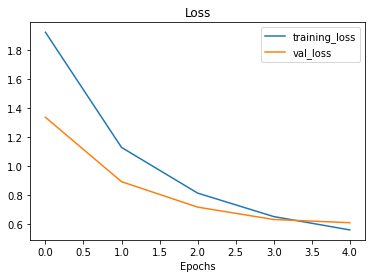

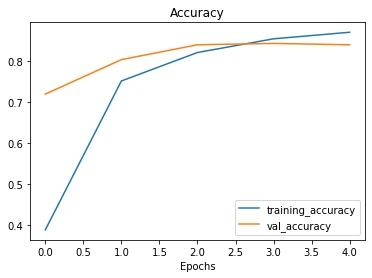

In [16]:
# Check out our model's training curve
plot_loss_curves(history_0)

## Getting a feature vector from a trained model 

Let's demonstrate the Global Average Pooling layer 2D layer ...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobaleAveragePooling2D, it turns into (None, 1280).

Let's use a similare shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D?

In [17]:
# Define the innput shape 
input_shape = (1, 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n)")

# Check the shape of the different tensors 
print(f'Shape of input tensor: {input_tensor.shape} ')
print(f'Shape of Global Average Pooling 2D tensor: {global_average_pooled_tensor.shape} ')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
)
Shape of input tensor: (1, 4, 4, 3) 
Shape of Global Average Pooling 2D tensor: (1, 3) 


In [18]:
# Lets replicate the GlobalAveragePool2D layer 
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> ⚒ **Practice:** Try to do the same of the above 2 cells, but this time using `GlobalMaxPool2D` ... and see what happens.

> 🔑**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer which can then be used to extract patterns out for our own specific problem. 

In [19]:
# Pass a tensor through Global MaxPool
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'Global Max Pooled tensor: {global_max_pool_tensor} ')

# Check the shape of the different tensors
print(f'Shape of input tensor : {input_tensor.shape} ')
print(f'Shape of GlobalMaxPooled tensor: {global_max_pool_tensor.shape} ')

Global Max Pooled tensor: [[0.9058464 1.1603122 1.6994323]] 
Shape of input tensor : (1, 4, 4, 3) 
Shape of GlobalMaxPooled tensor: (1, 3) 


In [20]:
tf.argmax(input_tensor)

<tf.Tensor: shape=(4, 4, 3), dtype=int64, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])>

## Running a series of transfer learning experiments 

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does iy=t go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model ... this ensures consistency across evaluation metrics.

### Getting and preprocessing our data for model_1

In [21]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 
unzip_data("10_food_classes_1_percent.zip")

--2022-10-20 13:00:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 74.125.130.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  40.2MB/s    in 3.2s    

2022-10-20 13:00:54 (40.2 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# Creating training and test dir 
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

In [23]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [24]:
# Setup data loaders 
IMG_SIZE  = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)  # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation directly into the model 

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprrocessing()`

We can see the benefits of doing this with the TensorFlow Data Augmentation focumentation.

Off the top of our head, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [25]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms , etc ...
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)   # Keep for models like 50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 511.5, 511.5, -0.5)

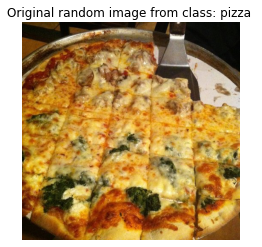

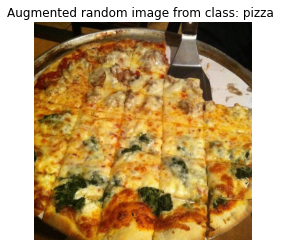

In [26]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
import numpy as np

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class: {target_class} ')
plt.axis(False)

# Now let's plot our augmented random image
augmented_image = data_augmentation(np.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class: {target_class} ")
plt.axis(False)

In [27]:
target_class = random.choice(train_data_1_percent.class_names)

## Model 1: Feature Extraction transfer learning on 1% od the data with data augmentation

In [28]:
from matplotlib.rcsetup import validate_animation_writer_path
from tensorflow.python import training
# Setup input shape and base model, freezing the base model layers 
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer 
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it 
x = base_model(x, training=False)

#  Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output 
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs 
model_1 = keras.Model(inputs, outputs)

# Compile the model 
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model 
history_1_percent = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(len(test_data)*0.25),
                        # Track model training logs
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name="1_percent_training_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_training_data_aug/20221020-130059
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4485 - accuracy: 0.0857 - val_loss: 2.2062 - val_accuracy: 0.2039
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1898 - accuracy: 0.2571 - val_loss: 2.0724 - val_accuracy: 0.2961
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9946 - accuracy: 0.3143 - val_loss: 1.9682 - val_accuracy: 0.3421
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7655 - accuracy: 0.5429 - val_loss: 1.8584 - val_accuracy: 0.4227
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6632 - accuracy: 0.6286 - val_loss: 1.7631 - val_accuracy: 0.4918


In [29]:
# Check out our model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate on the full test datset 
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.8017 - accuracy: 0.4568


[1.8016794919967651, 0.45680001378059387]

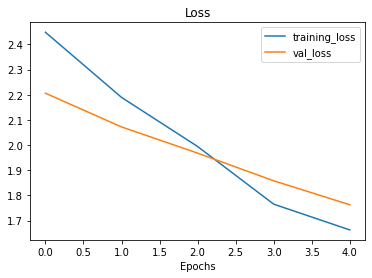

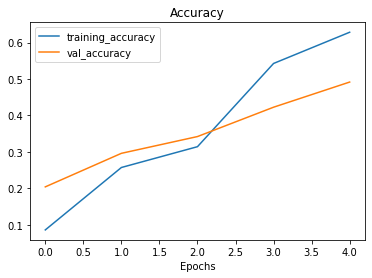

In [31]:
# How do the model with 1% of the data and data augmentation look like 
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of the training data

In [32]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = "10_food_classes_10_percent/test"

In [33]:
# How many images are in our directory 
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [34]:
# Setup data inputs 
import tensorflow as tf 
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)  
                                                                       

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# Create model 2 with data augmentation built in 
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer 
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50.2, you'll need to rescale your data, efficientnet has rescaling built-in
    ], name='data_augmentation')

# Setup the input shape to our model 
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur in test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated https://keras.io/guides/transfer_learning/
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile 
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



### Creating a ModelCheckpoint callback 

The ModelCheckpoint callback intermedially saves our model (the full model or just the weights= during training. This is useful so we can come and start where we left off.

In [36]:
# Set checkpoint path 
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoints.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', 
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint

In [37]:
# Fitting the model 
initial_epochs=5
history_10_percent_aug = model_2.fit(train_data_10_percent, 
                        epochs=5, 
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data, 
                        validation_steps=int(len(test_data) * 0.25),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                              experiment_name="10_percent_data_aug"),
                                  checkpoint_callback]) 

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221020-130138
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9691 - accuracy: 0.3587
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 19s 532ms/step - loss: 1.9691 - accuracy: 0.3587 - val_loss: 1.4320 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.7200
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 10s 393ms/step - loss: 1.2765 - accuracy: 0.7200 - val_loss: 0.9847 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.7760
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 10s 399ms/step - loss: 0.9814 - accuracy: 0.7760 - val_loss: 0.7854 - val_accuracy: 0.824

In [38]:
# What were model_0 results ?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.5613 - accuracy: 0.8592


[0.5612778067588806, 0.8592000007629395]

In [39]:
# Check model_2 results on all test data

results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6232 - accuracy: 0.8368


[0.6231539845466614, 0.8367999792098999]

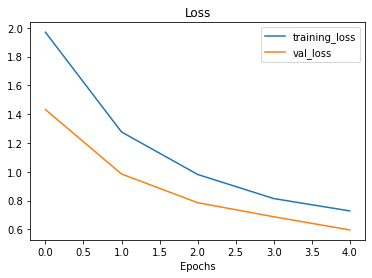

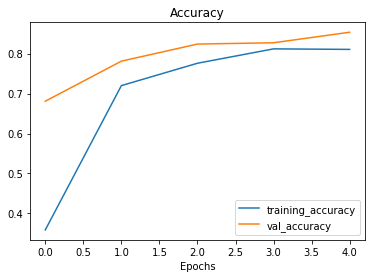

In [40]:
# Plot the model's loss curves
plot_loss_curves(history_10_percent_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoi,t

In [41]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6232 - accuracy: 0.8368


In [43]:
# If the results drom our previously evalyated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
results_10_percent_data_aug

[0.6231539845466614, 0.8367999792098999]

In [45]:
loaded_weights_model_results

[0.6231536865234375, 0.8367999792098999]

In [46]:
# Check to see if loaded model results are very close to our previous non-loaded model weights
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-Tuning ann existing model 

> 🔑 **Note:** Fine-Tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [47]:
# Layers in loaded model 
model_2.layers

In [48]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3741961cd0> True
<keras.engine.sequential.Sequential object at 0x7f3741961790> True
<keras.engine.functional.Functional object at 0x7f3741408dd0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f3741402850> True
<keras.layers.core.dense.Dense object at 0x7f37413ee650> True


In [49]:
# What layers are in our base_model (EfficientnetB0) and are they trainable ?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [50]:
# How many trainable variables are in our base models ?
print(len(model_2.layers[2].trainable_variables))

0


In [51]:
from prompt_toolkit.widgets import base
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True 
base_model.trainable = True 

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change):
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=['accuracy'])


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. how much?  This is a hyperparameter you can tune.But a good rule of thumb is at least 10x (thoygh different sources will claim other values).A good resource for information on this is the ULMFIT paper: https://arxiv.org/abs/1801.06146

In [52]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [53]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there ?
print(len(model_2.trainable_variables))

12


In [54]:
# Fine tune for another 5 epochs 
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data, 
                                               validation_steps=int(len(test_data) * 0.25),
                                               initial_epoch=history_10_percent_aug.epoch[-1],  # Start training from lpreivous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221020-130318
Epoch 5/10
24/24 [==============================] - 20s 485ms/step - loss: 0.6374 - accuracy: 0.8187 - val_loss: 0.5052 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 9s 352ms/step - loss: 0.5120 - accuracy: 0.8520 - val_loss: 0.4665 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - 10s 402ms/step - loss: 0.4523 - accuracy: 0.8707 - val_loss: 0.4473 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 9s 345ms/step - loss: 0.3926 - accuracy: 0.8933 - val_loss: 0.4201 - val_accuracy: 0.8536
Epoch 9/10
24/24 [==============================] - 9s 343ms/step - loss: 0.3777 - accuracy: 0.8813 - val_loss: 0.4397 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 10s 378ms/step - loss: 0.3066 - accuracy: 0.9160 - val_loss: 0.4114 - val_accuracy: 0.8635


In [55]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4042 - accuracy: 0.8636


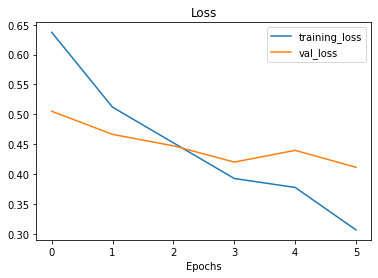

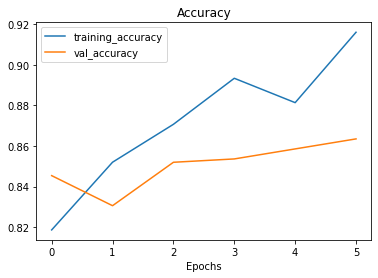

In [56]:
# Check out the loss_curves for our fine-tuned 
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series or running `fit()`with another (e.g. before and after fine-tuning)

In [57]:
# Let's create a function to compare training histories
def compare_histories(original_history,new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for Accuracy 
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy ')
  plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plots for Loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Val Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

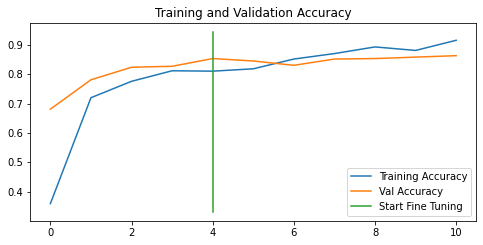

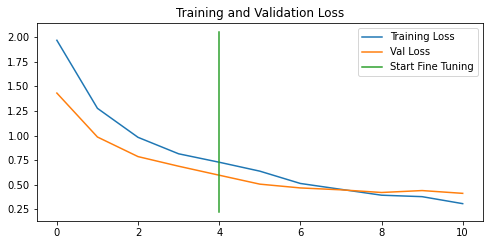

In [58]:
compare_histories(original_history=history_10_percent_aug, 
                 new_history=history_fine_10_percent_data_aug,
                  initial_epochs=5)

### Model 4: Fine-Tuning an existing model on all of the data

In [59]:
# Download and unzip 10 classes of Food101 data with all images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-10-20 13:04:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  64.3MB/s    in 7.8s    

2022-10-20 13:04:41 (63.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [60]:
# Setup training and test dir 
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = '10_food_classes_all_data/test'

In [61]:
# How many images are in our directories
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 

In [62]:
# Setup data inputs 
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data, 
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)

test_dr = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments ( all experiments use the same testing dataset).

Let's verify this ...

In [63]:
# Evaluate model_2 (this is fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4042 - accuracy: 0.8636


[0.4042185842990875, 0.8636000156402588]

In [64]:
results_fine_tune_10_percent

[0.4042186141014099, 0.8636000156402588]

To train a fine-tuning model (model_4) we need to revert model_2 to its feature extraction weights.

In [65]:
# Load weights from checkpoints, that way we can fine tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [66]:
# Let's evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6232 - accuracy: 0.8368


[0.6231539249420166, 0.8367999792098999]

In [67]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6231539845466614, 0.8367999792098999]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a Feature Extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we've saved the model's weights using `ModelCheckpoint` callback.
2. Fine-Tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to lode all the data (model_4)

In [68]:
# Check which layers are tunable in the whome model 
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [69]:
# Let's drill into our base model (efficientnetB0 ) and see wat layers are trainable 
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [70]:
# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [71]:
# Fit the model (100% od training data)
fine_tune_epochs = initial_epochs = + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(len(test_data)*0.25),
                                           initial_epoch=history_10_percent_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20221020-130500
Epoch 5/5
235/235 [==============================] - 66s 252ms/step - loss: 0.6549 - accuracy: 0.7893 - val_loss: 0.3651 - val_accuracy: 0.8750


In [72]:
# Let's evaluate on all of the data 
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 74ms/step - loss: 0.3456 - accuracy: 0.8844


[0.3455578088760376, 0.8844000101089478]

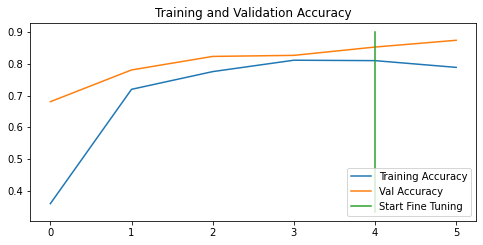

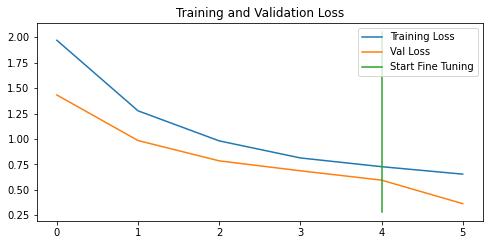

In [73]:
# How did fine-tuning go with more data 
compare_histories(original_history=history_10_percent_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

## View our experiment data on TensorBoard

> 🔑**Note:** Anything you upload on TensorBoard is going to be public.So, if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 classes" \
  --description 'A series of different transfer learning experiments with varying amounts of data and fine-tuning.'\
  --one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at:https://tensorboard.dev/experiment/XMDwJljfRg6WualeXv8Yog/#scalars 

In [76]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

https://tensorboard.dev/experiment/XMDwJljfRg6WualeXv8Yog/
	Name                 Transfer Learning Experiments with 10 Food101 classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   XMDwJljfRg6WualeXv8Yog
	Created              2022-10-20 13:16:47 (7 minutes ago)
	Updated              2022-10-20 13:16:56 (7 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  4361903
https://tensorboard.dev/experiment/AHW8PeBMSOmovnDWe6BBBQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   AHW8PeBMSOmovnDWe6BBBQ
	Created              2022-10-15 13:40:28
	Updated              2022-10-15 13:40:32
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes       

In [ ]:
# To delete an experiment 
#!tensorboard dev delete --experiment_id 